In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="anon", project="anon", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="anon", project="anon",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

query = {"$and": [
              {"tags": "submission"},
              {"tags": {"$ne": "data-efficiency"}},
              {"state": "finished"},
              {"config.n_train": 800},
              #{"config.body_args": [5]},
              #{"config.body_class": "ChainPendulum"},
              {"config.body_class": "Gyroscope"},
              {"config.network_class": "HNN"},
             ]}

runs, histories = zip(*get_history(query=query))
hnn_trainer, hnn_model = load_model_from_run(runs[0])

query = {"$and": [
              {"tags": "submission"},
              {"tags": {"$ne": "data-efficiency"}},
              {"state": "finished"},
              {"config.n_train": 800},
              #{"config.body_args": [5]},
              #{"config.body_class": "ChainPendulum"},
              {"config.body_class": "Gyroscope"},
              {"config.network_class": "CHNN"},
             ]}

runs, histories = zip(*get_history(query=query))
chnn_trainer, chnn_model = load_model_from_run(runs[0])

INFO:lightning:GPU available: True, used: False
/home/anon/miniconda3/envs/ham37v2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'pl_trainer.DynamicsModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/anon/miniconda3/envs/ham37v2/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'biases.models.hnn.HNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
Unimplemented OBJ format statement 's' on line 's off'
Unimplemented OBJ format statement 's' on line 's off'
/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load

tensor([0.0028, 0.0028, 0.0048], dtype=torch.float64) tensor([0.0024, 0.0024, 0.0004], dtype=torch.float64)
tensor(7.0659e-07, dtype=torch.float64)
tensor(5.7775e-07, dtype=torch.float64)
tensor(5.3929e-07, dtype=torch.float64)
HNN currently assumes potential energy depends only on q
HNN currently assumes time independent Hamiltonian
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [],
    'body_class': 'Gyroscope',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f6cb331b690>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyroscope/HNN/wandb/run-20200525_000359-150z1xaz/anon/version_150z1xaz/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.02,
    'euclidean': False,
    'exp_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyro

INFO:lightning:GPU available: True, used: False
Unimplemented OBJ format statement 's' on line 's off'
Unimplemented OBJ format statement 's' on line 's off'
/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.0041179656982421875
INFO:pywavefront:/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.0041179656982421875


tensor([0.0028, 0.0028, 0.0048], dtype=torch.float64) tensor([0.0024, 0.0024, 0.0004], dtype=torch.float64)
CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
--------------------------------
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 200,
    'body_args': [],
    'body_class': 'Gyroscope',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f6ca9074cd0>,
    'check_val_every_n_epoch': 100,
    'chunk_len': 5,
    'ckpt_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyroscope/CHNN/wandb/run-20200526_152410-2g4cb4uz/anon/version_2g4cb4uz/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 3,
    'dt': 0.02,
    'euclidean': True,
    'exp_dir': '/home/anon/repos/hamiltonian-biases/experiments/Gyroscope/CHNN',
    'fast_dev_run': False,
    'g

In [4]:
sns.set(font_scale=1.25)

In [5]:
from biases.utils import compute_moments
from biases.systems import Gyroscope
import networkx as nx
P = Gyroscope()
out = nx.get_edge_attributes(P.body_graph,"I")
I_3 = out[(0, '0_0')] + out[(0, '0_1')]

Unimplemented OBJ format statement 's' on line 's off'
Unimplemented OBJ format statement 's' on line 's off'
/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.0069732666015625
INFO:pywavefront:/mnt/storage1/Documents/repos/hamiltonian-biases/gyro.obj: Load time: 0.0069732666015625


tensor([0.0028, 0.0028, 0.0048], dtype=torch.float64) tensor([0.0024, 0.0024, 0.0004], dtype=torch.float64)


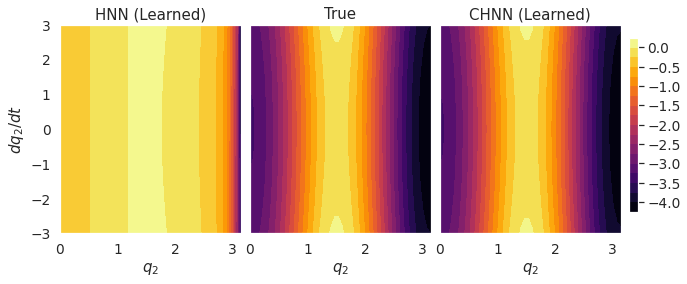

In [184]:
import torch
import math

ic_cartesian = P.sample_initial_conditions(1)
ic_euler = P.global2bodyCoords(ic_cartesian)

#n_dof = runs[0].config["body_args"][0]
num_angular_dims = 3
n_dof = 4
D = 3 # ambient dimension
n_per_dim = 50

q_vary = torch.linspace(0, math.pi, n_per_dim)
qdot_vary = torch.linspace(-3, 3, n_per_dim)

q_vary, qdot_vary = torch.meshgrid(q_vary, qdot_vary)
#qdot_vary, qdot_vary_ = torch.meshgrid(qdot_vary, qdot_vary)

#q_fixed = math.pi / 4 * torch.zeros_like(q_vary)
#qdot_fixed = 10 * torch.zeros_like(qdot_vary)

# Turn into N1 x N2 x ndof
#q_lst = [q_fixed] * num_angular_dims
#qdot_lst = [qdot_fixed] * num_angular_dims
#qdot_lst = [qdot_vary, qdot_fixed, qdot_vary_]
#q_lst = [q_fixed, q_vary, q_fixed]
q_lst = [torch.ones_like(q_vary) * ic_euler[0, 0, 0], q_vary, torch.ones_like(q_vary) * ic_euler[0, 0, 2]]

#qdot_lst = [qdot_fixed, qdot_vary, qdot_fixed]
qdot_lst = [torch.ones_like(q_vary) * ic_euler[0, 1, 0], qdot_vary, torch.ones_like(q_vary) * ic_euler[0, 1, 2]]

q = torch.stack(q_lst, dim=-1)
qdot = torch.stack(qdot_lst, dim=-1)

# Turn into N1*N2 x 2 x num_angular_dims
qqdot = torch.stack([q, qdot], dim=-2).reshape(n_per_dim * n_per_dim, 2, num_angular_dims)

# Turn into N1*N2 x 2 x ndof x D
xxdot = hnn_model.body.body2globalCoords(qqdot)
x, xdot = xxdot.chunk(2, dim=1)

with torch.no_grad():
    # Turn into N1*N2 x num_angular_dims
    hnn_q = q.reshape(n_per_dim * n_per_dim, num_angular_dims)
    hnn_p = hnn_model.model.M(hnn_q)(
        qdot.reshape(n_per_dim * n_per_dim, num_angular_dims)
    )
    # Turn into N1*N2 x 2*num_angular_dims
    hnn_qp = torch.cat([hnn_q, hnn_p], dim=-1)
    hnn_energies = hnn_model.model.H(torch.tensor(0.), hnn_qp).reshape(n_per_dim, n_per_dim)
    hnn_energies = torch.clamp(hnn_energies, min=-5, max=6)
    
    hnn_energies -= hnn_energies.mean()
    hnn_energies /= hnn_energies.std()
    
    hnn_v_eff = hnn_energies - hnn_p[:, 0].reshape(n_per_dim, n_per_dim).pow(2).div(2).div(I_3)
    #nn_v_eff -= hnn_v_eff.mean()
    #nn_v_eff /= hnn_v_eff.std()
    
    #hnn_energies = torch.clamp(hnn_energies, min=-1000000, max=4)
    
    
    true_p_euc = hnn_model.body.M @ xdot.double()
    true_xp_euc = torch.cat([x.double(), true_p_euc], dim=1)
    true_xp_euc = true_xp_euc.reshape(n_per_dim * n_per_dim, 2 * n_dof * D)
    true_energies = hnn_model.body.hamiltonian(None, true_xp_euc).reshape(n_per_dim, n_per_dim)
    
    true_energies -= true_energies.mean()
    true_energies /= true_energies.std()

    true_v_eff = true_energies - I_3 * (qdot[:, :, 0] + qdot[:, :, 2] * torch.cos(q[:, :, 1])).pow(2).div(2)
    #true_v_eff -= true_v_eff.mean()
    #true_v_eff /= true_v_eff.std()
    
    chnn_p_euc = chnn_model.model.M(xdot)
    # Turn into N1*N2 x 2*ndof*D
    chnn_xp_euc = torch.cat([x, chnn_p_euc], dim=1)
    chnn_xp_euc = chnn_xp_euc.reshape(n_per_dim * n_per_dim, 2 * n_dof * D)
    chnn_energies = chnn_model.model.H(torch.tensor(0.), chnn_xp_euc).reshape(n_per_dim, n_per_dim)

    chnn_energies -= chnn_energies.mean()
    chnn_energies /= chnn_energies.std()
    
    chnn_v_eff = chnn_energies - I_3 * (qdot[:, :, 0] + qdot[:, :, 2] * torch.cos(q[:, :, 1])).pow(2).div(2)
    #chnn_v_eff -= chnn_v_eff.mean()
    #chnn_v_eff /= chnn_v_eff.std()
        

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(3 * 4, 4))

#axes[0].contourf(q_vary, qdot_vary, hnn_energies, cmap="inferno", levels=20)
axes[0].contourf(q_vary, qdot_vary, hnn_v_eff, cmap="inferno", levels=20)
axes[0].set(title="HNN (Learned)")
axes[0].set(xlabel=r"$q_2$")
axes[0].set(ylabel=r"$dq_2/dt$")

#axes[1].contourf(q_vary, qdot_vary, true_energies, cmap="inferno", levels=20)
axes[1].contourf(q_vary, qdot_vary, true_v_eff, cmap="inferno", levels=20)
axes[1].set(title="True")
axes[1].set(yticklabels=[])
axes[1].set(xlabel=r"$q_2$")

#heatmap = axes[2].contourf(q_vary, qdot_vary, chnn_energies, cmap="inferno", levels=20)
heatmap = axes[2].contourf(q_vary, qdot_vary, chnn_v_eff, cmap="inferno", levels=20)
axes[2].set(title="CHNN (Learned)")
axes[2].set(yticklabels=[])
axes[2].set(xlabel=r"$q_2$")

cbar = fig.colorbar(heatmap, ax=axes.ravel().tolist(), shrink=0.8)
#fig.suptitle("ChainPendulum("+ f"{n_dof}" + ") Hamiltonians " 
#             + r"($q_i = \pi, dq_i/dt = 5$ for $i = 1,\ldots, 4$)"
#             , fontsize=16)
fig.subplots_adjust(top=0.85, right=0.774, wspace=0.05)

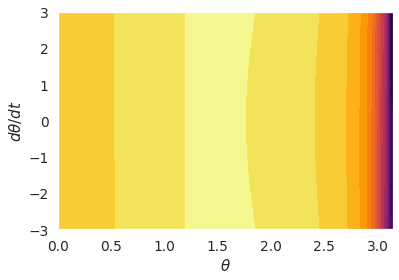

In [185]:
fig, ax = plt.subplots()

ax.contourf(q_vary, qdot_vary, hnn_v_eff, cmap="inferno", levels=20)
ax.set(xlabel=r"$\theta$")
ax.set(ylabel=r"$d\theta/dt$")
fig.savefig("gyroscope-hnn-veff.pdf", bbox_inches="tight")

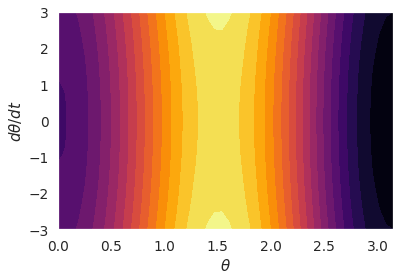

In [186]:
fig, ax = plt.subplots()

ax.contourf(q_vary, qdot_vary, true_v_eff, cmap="inferno", levels=20)
ax.set(xlabel=r"$\theta$")
ax.set(ylabel=r"$d\theta/dt$")
fig.savefig("gyroscope-true-veff.pdf", bbox_inches="tight")

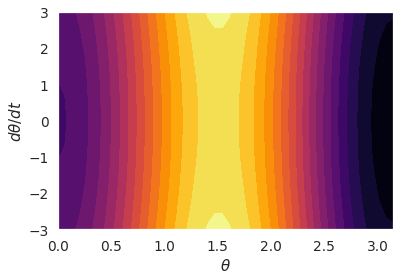

In [187]:
fig, ax = plt.subplots()

ax.contourf(q_vary, qdot_vary, chnn_v_eff, cmap="inferno", levels=20)
ax.set(xlabel=r"$\theta$")
ax.set(ylabel=r"$d\theta/dt$")
fig.savefig("gyroscope-chnn-veff.pdf", bbox_inches="tight")